<a href="https://colab.research.google.com/github/VDliveson/USG-Fetal-classification/blob/main/fetus_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras.models import load_model
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet169
from keras.models import Sequential
import pandas as pd
import os
import shutil
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Making file structure

In [ ]:
# !curl https://zenodo.org/record/3904280/files/FETAL_PLANES_ZENODO.zip?download=1 -o fetus.zip

In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/fetus dataset/FETAL_PLANES_ZENODO.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="/content/temp")


In [ ]:
# folder_path = r'/content/temp/Images'
# img_list = os.listdir(folder_path)

# if not os.path.exists('/content/temp1'):
#     os.mkdir('/content/temp1')
# out_folder = r'/content/temp1'

# i=0
# for img in img_list:
#     print(i)
#     img_path = os.path.join(folder_path,img)
#     out_path = os.path.join(out_folder,img)
#     img = cv2.imread(img_path,0)
#     # nlmeans_denoised = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)  # 10 is the filter strength, 7 is the h value, 21 is the window size, adjust as needed
#     # gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
#     median_filtered = cv2.medianBlur(image, 5)
#     cv2.imwrite(out_path,median_filtered)
#     i=i+1


In [ ]:
df = pd.read_excel(r'/content/temp/FETAL_PLANES_DB_data.xlsx')
df.head()


def get_class_images(df,class_name,folder_path):
    images_names = list(df[df['Plane']==class_name]['Image_name'])
    names = []
    for i in range(int(len(images_names))):
        names.append(images_names[i]+'.png')
    return names



images_path = r'/content/temp/Images'

class_names = list(df['Plane'].unique())
class_folder_names = [i.lower().replace(' ', '_') for i in class_names]

if not os.path.exists('/content/data'):
    os.mkdir('/content/data')
data_path = r'/content/data'

for i in range(len(class_folder_names)):
    folder_path = os.path.join(data_path,class_folder_names[i])
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    class_images = get_class_images(df,class_names[i],images_path)
    for img in class_images:
        img_path = os.path.join(images_path,img)
        out_path = os.path.join(folder_path,img)
        shutil.copy(img_path,out_path)

In [ ]:
if not os.path.exists("/content/models"):
    os.mkdir("/content/models")

In [ ]:
!pip install split-folders
import splitfolders
data_folder = r'/content/data'
splitfolders.ratio(data_folder, output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 12400 files [00:07, 1725.54 files/s]


## Data cleaning

In [ ]:
from scipy.ndimage.filters import uniform_filter
from pylab import *
import cv2


from PIL import Image, ImageFilter


def crimmins(data):
    new_image = data.copy()
    nrow = len(data)
    ncol = len(data[0])

    # Dark pixel adjustment

    # First Step
    # N-S
    for i in range(1, nrow):
        for j in range(ncol):
            if data[i-1,j] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if data[i,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow):
        for j in range(1, ncol):
            if data[i-1,j-1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    #NE-SW
    for i in range(1, nrow):
        for j in range(ncol-1):
            if data[i-1,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i-1,j] > data[i,j]) and (data[i,j] <= data[i+1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] > data[i,j]) and (data[i,j] <= data[i,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j-1] > data[i,j]) and (data[i,j] <= data[i+1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j+1] > data[i,j]) and (data[i,j] <= data[i+1,j-1]):
                new_image[i,j] += 1
    data = new_image
    #Third Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i+1,j] > data[i,j]) and (data[i,j] <= data[i-1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j-1] > data[i,j]) and (data[i,j] <= data[i,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j+1] > data[i,j]) and (data[i,j] <= data[i-1,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j-1] > data[i,j]) and (data[i,j] <= data[i-1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image

    # Light pixel adjustment

    # First Step
    # N-S
    for i in range(1,nrow):
        for j in range(ncol):
            if (data[i-1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if (data[i,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow):
        for j in range(1,ncol):
            if (data[i-1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow):
        for j in range(ncol-1):
            if (data[i-1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i-1,j] < data[i,j]) and (data[i,j] >= data[i+1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] < data[i,j]) and (data[i,j] >= data[i,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j-1] < data[i,j]) and (data[i,j] >= data[i+1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j+1] < data[i,j]) and (data[i,j] >= data[i+1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # Third Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i+1,j] < data[i,j]) and (data[i,j] >= data[i-1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol-1):
            if (data[i,j-1] < data[i,j]) and (data[i,j] >= data[i,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j+1] < data[i,j]) and (data[i,j] >= data[i-1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j-1] < data[i,j]) and (data[i,j] >= data[i-1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    return new_image.copy()



img = cv2.imread('/content/output/train/fetal_abdomen/Patient00168_Plane2_1_of_2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


image2 = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
image2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# imshow(img, vmin=0, vmax=1, cmap='gray')
# imshow(lee_filter(img, 20), vmin=0, vmax=1, cmap='gray')


# image2 = Image.fromarray(image2.astype('uint8'))
# image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
new_image = crimmins(image2)

plt.figure(figsize=(11,6))
plt.subplot(121), plt.imshow(image2, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new_image, cmap='gray'),plt.title('Crimmins Smoothing')
plt.xticks([]), plt.yticks([])
plt.show()

<ipython-input-43-53b34f943f0a>:1: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter


error: ignored

## Test and train dataset generator

In [ ]:
!nvidia-smi

Fri Jun 30 08:35:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |    387MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory

TARGET_SHAPE = (224,224)
BATCH_SIZE = 32
train_dir = "output/train" #ex: images/train/
test_dir = "output/val" #ex: images/test/

classes = os.listdir(train_dir)


train_data_gen = image_dataset_from_directory(batch_size=BATCH_SIZE,
                                              class_names = classes,
                                              directory=train_dir,
                                              image_size=TARGET_SHAPE,
                                              shuffle=True,
                                              )

test_data_gen = image_dataset_from_directory(batch_size=BATCH_SIZE,
                                              class_names = classes,
                                              directory=test_dir,
                                              image_size=TARGET_SHAPE,
                                              shuffle=True,
                                              )


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.1, fill_mode='reflect',
                                                            interpolation='bilinear'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2),
                                                         fill_mode='reflect', interpolation='bilinear'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1),
                                                                fill_mode='reflect', interpolation='bilinear'),
])



def normalize_images(images, labels):
    # Convert pixel values to float32
    images = tf.cast(images, tf.float32)
    # Normalize pixel values from [0, 255] to [-1, 1] range
    images = (images / 127.5) - 1.0
    return images, labels

# Apply normalization to the loaded dataset
# train_data_gen = train_data_gen.map(normalize_images)
# # train_data_gen = train_data_gen.map(lambda x, y: (data_augmentation(x, training=True), y))
# test_data_gen = test_data_gen.map(normalize_images)


train_data_gen = train_data_gen.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_gen = test_data_gen.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 9917 files belonging to 6 classes.
Found 2483 files belonging to 6 classes.


## Load model definition

In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

import tensorflow as tf

from classification_models.tfkeras import Classifiers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50, ResNet101, ResNet152
# from keras.applications.resnet import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152

# from keras.applications.resnext import ResNeXt50, ResNeXt101
# from keras.applications.senet import SENet, SEResNet50, SEResNet101, SEResNet152, SEResNeXt50, SEResNeXt101
ResNet18,preprocess_input = Classifiers.get('resnet18')
ResNet34,preprocess_input = Classifiers.get('resnet34')

ResNeXt50,preprocess_input = Classifiers.get('resnext50')
ResNeXt101,preprocess_input = Classifiers.get('resnext101')


SENet,preprocess_input = Classifiers.get('senet154')
SEResNet50,preprocess_input = Classifiers.get('seresnet50')
SEResNet101,preprocess_input = Classifiers.get('seresnet101')
SEResNet152,preprocess_input = Classifiers.get('seresnet152')
SEResNeXt50,preprocess_input = Classifiers.get('seresnext50')
SEResNeXt101,preprocess_input = Classifiers.get('seresnext101')

from keras.applications.densenet import DenseNet121, DenseNet169


  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-34pjei0p
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-34pjei0p
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=2a6a2909abdc9c88f4244e3e76a79a741d7fcd6fa55fb6e3d42856bb74766473
  Stored in directory: /tmp/pip-ephem-wheel-cache-2sugiall/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image-classifiers


In [ ]:
# InceptionV3,


model_variables = [
    VGG16,
    VGG19,
    MobileNet,
    ResNet18,
    ResNet34,
    ResNet50,
    ResNet101,
    ResNet152,
    ResNeXt50,
    ResNeXt101,
    SENet,
    SEResNet50,
    SEResNet101,
    SEResNet152,
    SEResNeXt50,
    SEResNeXt101,
    DenseNet121,
    DenseNet169
]

model_names = [
    'VGG16',
    'VGG19',
    'MobileNet',
    'ResNet18',
    'ResNet34',
    'ResNet50',
    'ResNet101',
    'ResNet152',
    'ResNeXt50',
    'ResNeXt101',
    'SENet',
    'SEResNet50',
    'SEResNet101',
    'SEResNet152',
    'SEResNeXt50',
    'SEResNeXt101',
    'DenseNet121',
    'DenseNet169'
]

## Other users

In [ ]:
from IPython.display import clear_output

IMAGE_SIZE  = [224,224]

accuracy_dict = {}

for it in range(17,18):
    clear_output(wait=True)
    print(model_names[it],' is being Trained\n\n')


    if it == 17 or it == 16:
        model_init = model_variables[it](input_shape=IMAGE_SIZE  + [3], weights ='imagenet', include_top=False)
    else:
        model_init = model_variables[it](input_shape=IMAGE_SIZE  + [3], weights = 'imagenet', include_top=False)
    # print(model_init.summary())


    model_init.trainable=False
    batch_norm = tf.keras.layers.BatchNormalization()
    rescaling_layer = tf.keras.layers.Rescaling(1./255,input_shape=IMAGE_SIZE  + [3])
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    # mirroring and shifting layers
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal", seed = 42),
        #tf.keras.layers.RandomTranslation(height_factor = (-0.15, 0.15), width_factor = (-0.15, 0.15), fill_mode = "nearest", seed = 42),
    ])

    # normalization layer
    normalize = tf.keras.layers.Normalization()

    prediction_layer = tf.keras.layers.Dense(len(classes),activation='softmax')
    model = tf.keras.Sequential([
        rescaling_layer,
        data_augmentation,
        model_init,
        batch_norm,
        global_average_layer,
        prediction_layer
    ])

    print(model.summary())
    print("Training : ")

    model.compile(optimizer=tf.optimizers.Adam(),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=["accuracy"])

    history = model.fit(train_data_gen,
                    epochs=10,
                    steps_per_epoch=2,
                    validation_steps=2,
                    validation_data=test_data_gen)


    validation_steps = 20

    loss0,accuracy0 = model.evaluate(test_data_gen, steps = validation_steps)

    print(model_names[it], 'gives us :')
    print("loss: {:.2f}".format(loss0))
    print("accuracy: {:.2f}".format(accuracy0))

    accuracy_dict.update({model_names[it]:[loss0,accuracy0]})

    model.save("models/"+str(model_names[it])+".h5")


DenseNet169  is being Trained


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 1664)       6656      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_6   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)      

KeyboardInterrupt: ignored

In [ ]:
accuracy_dict

## V layers

In [ ]:
from IPython.display import clear_output

IMAGE_SIZE  = [224,224]

accuracy_dict = {}

for it in range(17,18):
    clear_output(wait=True)
    print(model_names[it],' is being Trained\n\n')

    model_init = model_variables[it](input_shape=IMAGE_SIZE  + [3], weights = 'imagenet', include_top=False)
    # print(model_init.summary())


    model_init.trainable=False
    batch_norm = tf.keras.layers.BatchNormalization()
    # rescaling_layer = tf.keras.layers.Rescaling(scale=1./255,input_shape=IMAGE_SIZE  + [3])
    rescaling_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1,input_shape=IMAGE_SIZE  + [3])
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    # normalization layer
    # normalize = tf.keras.layers.Normalization()

    prediction_layer = tf.keras.layers.Dense(len(classes),activation='softmax')
    model = tf.keras.Sequential([
        # rescaling_layer,
        model_init,
        global_average_layer,
        batch_norm,
        prediction_layer
    ])

    print(model.summary())
    print("Training : ")

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    model.compile(optimizer=tf.optimizers.Adam(),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=["accuracy"])

    # history = model.fit(train_data_gen,
    #                 epochs=100,
    #                 steps_per_epoch=2,
    #                 validation_steps=2,
    #                 validation_data=test_data_gen,callbacks=[callback])

    history = model.fit(train_data_gen,
                    epochs=100,
                    steps_per_epoch=2,
                    validation_steps=2,
                    validation_data=test_data_gen)


    validation_steps = 20

    loss0,accuracy0 = model.evaluate(test_data_gen, steps = validation_steps)

    print(model_names[it], 'gives us :')
    print("loss: {:.2f}".format(loss0))
    print("accuracy: {:.2f}".format(accuracy0))

    accuracy_dict.update({model_names[it]:[loss0,accuracy0]})

    model.save("models/"+str(model_names[it])+".h5")


DenseNet169  is being Trained


51877672/51877672 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 6)                 9990      
                                                                 
Total params: 12,659,526
Trainable params: 13,318
Non-trainable params: 12,646,208
______

In [ ]:
accuracy_dict


{'DenseNet169': [0.5737414956092834, 0.8109375238418579]}

In [ ]:
classes = ['fetal_abdomen',
 'fetal_brain',
 'other',
 'fetal_femur',
 'fetal_thorax',
 'maternal_cervix']

In [ ]:
import cv2 as cv2
img = cv2.imread('/content/Image1-cropped.jpg')
img = cv2.resize(img,(224,224))
new_img = np.expand_dims(img, axis=0)
img.shape

(224, 224, 3)

In [ ]:
classes = os.listdir(train_dir)
pred = model.predict(new_img)
target = classes[np.argmax(pred)]
target

1/1 [==============================] - 0s 33ms/step


'fetal_femur'

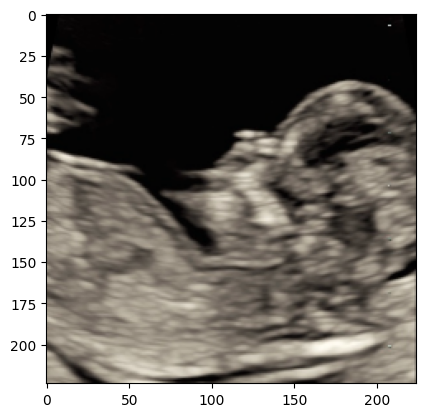

In [ ]:
plt.imshow(img)